In [9]:
# Cell 1
# STEP 1: DATA PREPARATION
#

import sqlite3
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def load_data_from_db(db_name="fightaging_articles.db"):
    """Loads articles from the database into a Pandas DataFrame."""
    try:
        conn = sqlite3.connect(db_name)
        df = pd.read_sql_query("SELECT * FROM articles", conn)
        conn.close()
        df['publish_date'] = pd.to_datetime(df['publish_date'])
        print(f"Loaded {len(df)} articles from the database.") # Se cargaron {len(df)} artículos de la base de datos.
        return df
    except Exception as e:
        print(f"Error loading data: {e}") # Error al cargar datos: {e}
        return pd.DataFrame()

def clean_text(text):
    """
    Function to clean the text:
    1. Converts to lowercase.
    2. Removes punctuation and numbers.
    3. Splits the text into words (tokenization).
    4. Removes "stop words" (common English words).
    5. Removes very short words (1 or 2 letters).
    """
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove punctuation and numbers using regular expressions
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenization (split into words)
    tokens = word_tokenize(text)
    
    # 4. Remove stop words
    stop_words = set(stopwords.words('english'))
    
    # We add some custom words that are very common in this context
    # but do not contribute much meaning to differentiate topics.
    custom_stop_words = [
        'welcome', 'fight', 'also', 'study', 'research', 'aging', 'age', 'may', 
        'however', 'results', 'data', 'found', 'open', 'access', 
        'great', 'deal', 'one', 'even', 'work', 'life', 'people', 'years', 'healthy',
        'life', 'longevity', 'human'
    ]
    stop_words.update(custom_stop_words)
    
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # 5. Remove very short words
    filtered_tokens = [word for word in filtered_tokens if len(word) > 2]
    
    # Join the words back into a single string
    return " ".join(filtered_tokens)


# --- Execution of Step 1 ---

if __name__ == "__main__":
    articles_df = load_data_from_db()

    if not articles_df.empty:
        # We combine title and body for a more complete analysis
        articles_df['full_text'] = articles_df['title'] + ' ' + articles_df['body']
        
        print("\nCleaning and preprocessing the articles' text...") # Limpiando y preprocesando el texto de los artículos...
        # We apply the cleaning function to each article
        articles_df['cleaned_text'] = articles_df['full_text'].apply(clean_text)
        
        # We show a before and after comparison
        print("\nCleaning example:") # Ejemplo de limpieza:
        print("--- ORIGINAL TEXT ---") # --- TEXTO ORIGINAL ---
        print(articles_df['full_text'].iloc[1][:500]) # Shows the first 500 characters
        print("\n--- CLEANED TEXT ---") # --- TEXTO LIMPIO ---
        print(articles_df['cleaned_text'].iloc[1][:500])
        
        # We save the processed DataFrame so we don't have to repeat this step
        articles_df.to_pickle("articles_cleaned.pkl")
        print("\nDataFrame with clean text saved to 'articles_cleaned.pkl'") # DataFrame con texto limpio guardado en 'articles_cleaned.pkl'

Loaded 18753 articles from the database.

Cleaning and preprocessing the articles' text...

Cleaning example:
--- ORIGINAL TEXT ---
The Fight Aging! Disclaimer Please read this disclaimer carefully. It is a commonsense statement that should apply to all health information you find online. Your health is valuable and easily damaged. What is good advice for one person may not be good advice for another: people vary considerably in health matters. Information provided on Fight Aging! should always be discussed with a qualified physician. It is not intended to replace the relationship between you and your physician. It is recomm

--- CLEANED TEXT ---
disclaimer please read disclaimer carefully commonsense statement apply health information find online health valuable easily damaged good advice person good advice another vary considerably health matters information provided always discussed qualified physician intended replace relationship physician recommended follow topics interest intern

In [10]:
import os

output_path = '2. NER_Analysis'

# Create the directory if it doesn't exist
# We use output_path directly here.
os.makedirs(output_path, exist_ok=True)
print(f"Directory created or already exists: {output_path}")

Directory created or already exists: 2. NER_Analysis


In [11]:
# Cell 2
# STEP 2: VECTORIZATION
#

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# We load the DataFrame that we cleaned in the previous step
try:
    articles_df = pd.read_pickle("articles_cleaned.pkl")
    print("DataFrame with clean text loaded correctly.") # DataFrame con texto limpio cargado correctamente.
except FileNotFoundError:
    print("Error: The file 'articles_cleaned.pkl' was not found.") # Error: El archivo 'articles_cleaned.pkl' no fue encontrado.
    print("Please, run the script from Step 1 first to generate this file.") # Por favor, ejecuta primero el script del Paso 1 para generar este archivo.
    exit()

# We make sure there are no empty texts that could cause problems
articles_df.dropna(subset=['cleaned_text'], inplace=True)
corpus = articles_df['cleaned_text']

DataFrame with clean text loaded correctly.


In [12]:
import pandas as pd
import spacy
from tqdm.auto import tqdm
import os

# --- CONTROL PARAMETERS ---
SAMPLE_MODE = False  # 👈 Change to False to process all data
SAMPLE_SIZE = 200   # Defines how many articles to use in sample mode
# -----------------------------

# --- CORRECTION: Unified file name ---
output_file = "articles_with_final_entities.pkl"

if os.path.exists(output_file) and not SAMPLE_MODE:
    print(f"✅ The file '{output_file}' already exists. Skipping step and loading.") # El archivo '{output_file}' ya existe. Saltando el paso y cargando.
    df = pd.read_pickle(output_file)
else:
    print("\n--- STEP 4 (No Rules): DOUBLE-MODEL EXTRACTION ---") # PASO 4 (Sin Reglas): EXTRACCIÓN CON DOBLE MODELO

    # 1. Load the DataFrame
    df = pd.read_pickle("articles_cleaned.pkl")
    if SAMPLE_MODE:
        print(f"⚠️  SAMPLE MODE ACTIVE. Processing {SAMPLE_SIZE} articles.") # MODO DE MUESTRA ACTIVO. Procesando {SAMPLE_SIZE} artículos.
        df = df.sample(n=SAMPLE_SIZE, random_state=42)

    # 2. Load BOTH models
    print("Loading general model 'en_core_web_sm' (for acronyms)...") # Cargando modelo general 'en_core_web_sm' (para siglas)...
    nlp_general = spacy.load("en_core_web_sm")
    
    print("Loading expert model 'en_core_sci_lg' (for concepts)...") # Cargando modelo experto 'en_core_sci_lg' (para conceptos)...
    nlp_experto = spacy.load("en_core_sci_lg")

    # 3. Definition of the extraction function (WITHOUT EntityRuler)
    def extract_entities_doble_modelo(text: str) -> dict:
        entities = {}
        # Extractor A: General Model to discover acronyms
        doc_general = nlp_general(text, disable=['parser', 'tagger'])
        for ent in doc_general.ents:
            if ent.label_ in ['ORG', 'PRODUCT']:
                if len(ent.text.split()) <= 2 and len(ent.text) < 15:
                     entities.setdefault('ACRONYM_OR_BIOMARKER', []).append(ent.text)

        # Extractor B: Expert Model to discover biomedical entities
        doc_experto = nlp_experto(text, disable=['parser', 'tagger'])
        expert_labels = ['GENE_OR_GENE_PRODUCT', 'CHEMICAL', 'DISEASE', 'THERAPEUTIC', 'METHOD']
        for ent in doc_experto.ents:
            if ent.label_ in expert_labels:
                entities.setdefault(ent.label_, []).append(ent.text)
        
        # Clean duplicates
        for label in entities:
            entities[label] = list(set(entities[label]))
        return entities

    # 4. Apply the new function
    print(f"Applying NER with double model to {len(df)} articles...") # Aplicando NER con doble modelo a {len(df)} artículos...
    TEXTO_FUENTE_NER = df['full_text'].fillna('')
    tqdm.pandas()
    df['final_entities'] = TEXTO_FUENTE_NER.progress_apply(extract_entities_doble_modelo)

    # 5. Save
    print("\n✅ Entity extraction completed.") # Extracción de entidades completada.
    if not SAMPLE_MODE:
        df.to_pickle(output_file)
        print(f"\n✅ Complete DataFrame saved to '{output_file}'.") # DataFrame completo guardado en '{output_file}'.

print("\n--- DataFrame 'df' ready for analysis in the next cell ---") # DataFrame 'df' listo para el análisis en la siguiente celda

✅ The file 'articles_with_final_entities.pkl' already exists. Skipping step and loading.

--- DataFrame 'df' ready for analysis in the next cell ---



--- STEP 5: TREND ANALYSIS AND VISUALIZATION ---

Filtering results...
Found 17822 mentions of relevant entities after filtering.

--- Top 30 Molecules, Treatments, and Genes (Filtered Result) ---
entity_name
SASP             301
Drosophila       245
IGF-1            208
mTOR             181
IL-6             161
Hayflick         160
NAD+             154
Alcor            109
SIRT1            107
AMPK             100
Autophagy         90
APOE              83
mTORC1            76
IL-1β             71
MPrize            65
Rapamycin         63
NLRP3             62
VEGF              60
FOXO              51
TGF-β             50
Kurzweil          50
Caloric           46
Huntington        45
C57BL/6J          44
IL-10             41
Cryonics          39
Laron             37
Hematopoietic     37
Biobank           35
Calico            35
Name: count, dtype: int64

Generating plot for: Biomarkers and Chemicals


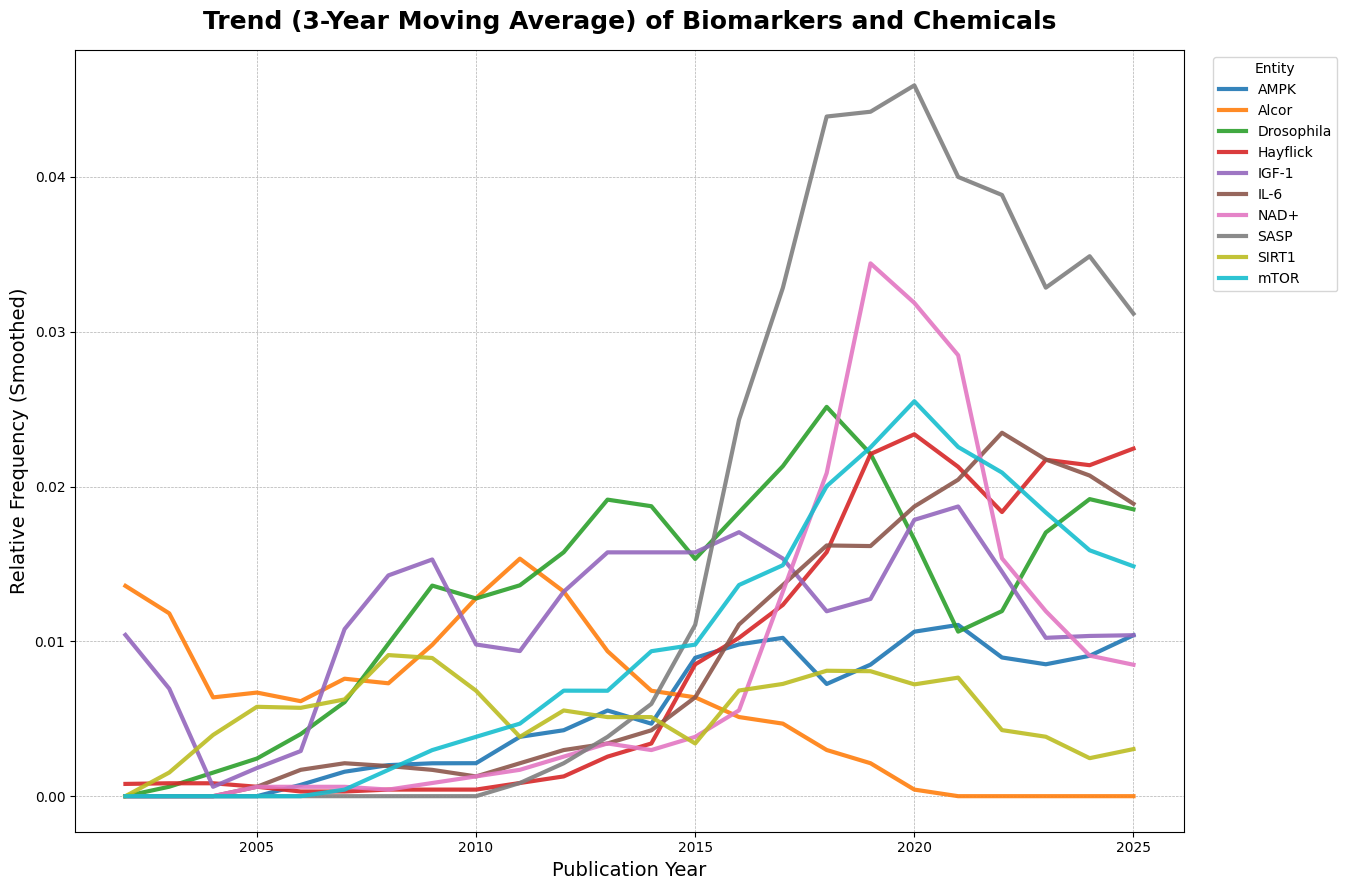


No data found for the plot group: Therapies and Diseases


In [ ]:
# STEP 5: TREND ANALYSIS AND VISUALIZATION

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n--- STEP 5: TREND ANALYSIS AND VISUALIZATION ---")

# The DataFrame 'df' already exists in memory or can be loaded if the kernel is restarted
if 'df' not in locals():
    try:
        print("DataFrame not found in memory, loading from file...")
        df = pd.read_pickle("articles_with_final_entities.pkl")
    except FileNotFoundError:
        print("❌ Error: 'articles_with_final_entities.pkl' not found. Run the previous cell first.")
        exit()

# 1. Unnest and filter entities
df['year'] = pd.to_datetime(df['publish_date']).dt.year
entities_list = []
for index, row in df.iterrows():
    year = row['year']
    article_id = index
    for label, entities in row.get('final_entities', {}).items():
        for entity in entities:
            entities_list.append({
                'year': year, 'entity_name': entity.strip(), 'entity_type': label, 'article_id': article_id
            })
entities_df = pd.DataFrame(entities_list)

stop_entities = [
    'aging', 'research', 'years', 'mice', 'cells', 'researchers', 'people', 'human', 'age', 'longevity', 'brain', 
    'study', 'associated with', 'healthy', 'patients', 'levels', 'increased', 'results', 'studies', 'disease', 
    'development', 'damage', 'life', 'health', 'effects', 'years ago', 'body', 'dna', 'treatments', 'treatment', 
    'cell', 'data', 'information', 'university', 'institute', 'foundation', 'sciencedaily', 'fight aging', 'aging evidence',
    'eurekalert', 'google', 'linear', 'time', 'harvard', 'longevity meme', 'methuselah', 'medical news', 'pubmed', 'youtube',
    'msnbc', 'stanford', 'medicare', 'futurepundit', 'science', 'congress', 'ending aging', 'senate', 'ucla'
]
TARGET_LABELS = [
    'ACRONYM_OR_BIOMARKER', 'GENE_OR_GENE_PRODUCT', 'CHEMICAL', 'THERAPEUTIC', 'DISEASE', 'METHOD'
]

print("\nFiltering results...") # Filtrando resultados...
entities_df['entity_lower'] = entities_df['entity_name'].str.lower()
clean_entities_df = entities_df[~entities_df['entity_lower'].isin(stop_entities)]
clean_entities_df = clean_entities_df[clean_entities_df['entity_name'].str.len() > 3]
clean_entities_df = clean_entities_df[clean_entities_df['entity_type'].isin(TARGET_LABELS)]
print(f"Found {len(clean_entities_df)} mentions of relevant entities after filtering.")

# 2. Top Entities Analysis (what used to be Cell B)
print("\n--- Top 30 Molecules, Treatments, and Genes (Filtered Result) ---")
print(clean_entities_df['entity_name'].value_counts().head(30))

# 3. Preparation for Trend Visualization
entity_groups = {
    'Biomarkers and Chemicals': ['ACRONYM_OR_BIOMARKER', 'GENE_OR_GENE_PRODUCT', 'CHEMICAL'], # Biomarcadores y Químicos
    'Therapies and Diseases': ['THERAPEUTIC', 'DISEASE', 'METHOD'] # Terapias y Enfermedades
}
unique_mentions = clean_entities_df.drop_duplicates(subset=['year', 'entity_name', 'article_id'])
entity_trends = unique_mentions.groupby(['year', 'entity_name', 'entity_type']).size().reset_index(name='count')
total_articles_per_year = df.groupby('year').size().reset_index(name='total_articles')
entity_trends = pd.merge(entity_trends, total_articles_per_year, on='year')
entity_trends['frequency'] = entity_trends['count'] / entity_trends['total_articles']

# 4. Iterate and Plot
for group_name, labels in entity_groups.items():
    group_df = entity_trends[entity_trends['entity_type'].isin(labels)]
    if group_df.empty:
        print(f"\nNo data found for the plot group: {group_name}")
        continue

    N_TOP_ENTITIES = 10
    top_entities_in_group = group_df.groupby('entity_name')['count'].sum().nlargest(N_TOP_ENTITIES).index
    plot_df = group_df[group_df['entity_name'].isin(top_entities_in_group)]
    
    if plot_df.empty:
        print(f"\nNot enough data in the top {N_TOP_ENTITIES} to plot the group: {group_name}")
        continue

    all_years = range(df['year'].min(), df['year'].max() + 1)
    plot_pivot = plot_df.pivot_table(index='year', columns='entity_name', values='frequency').reindex(all_years).fillna(0)
    smoothed_pivot = plot_pivot.rolling(window=3, min_periods=1, center=True).mean()
    plot_ready_df = smoothed_pivot.melt(var_name='entity_name', value_name='smoothed_frequency', ignore_index=False).reset_index()

    print(f"\nGenerating plot for: {group_name}") # Generando gráfico para: {group_name}
    plt.figure(figsize=(16, 9))
    sns.lineplot(data=plot_ready_df, x='year', y='smoothed_frequency', hue='entity_name', linewidth=3, alpha=0.9)
    plt.title(f'Trend (3-Year Moving Average) of {group_name}', fontsize=18, weight='bold', pad=15)
    plt.xlabel('Publication Year', fontsize=14)
    plt.ylabel('Relative Frequency (Smoothed)', fontsize=14)
    plt.legend(title='Entity', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(f'2. NER_Analysis/tendencia_{group_name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()


--- STEP 7: Generating Entity Trend Heatmap ---


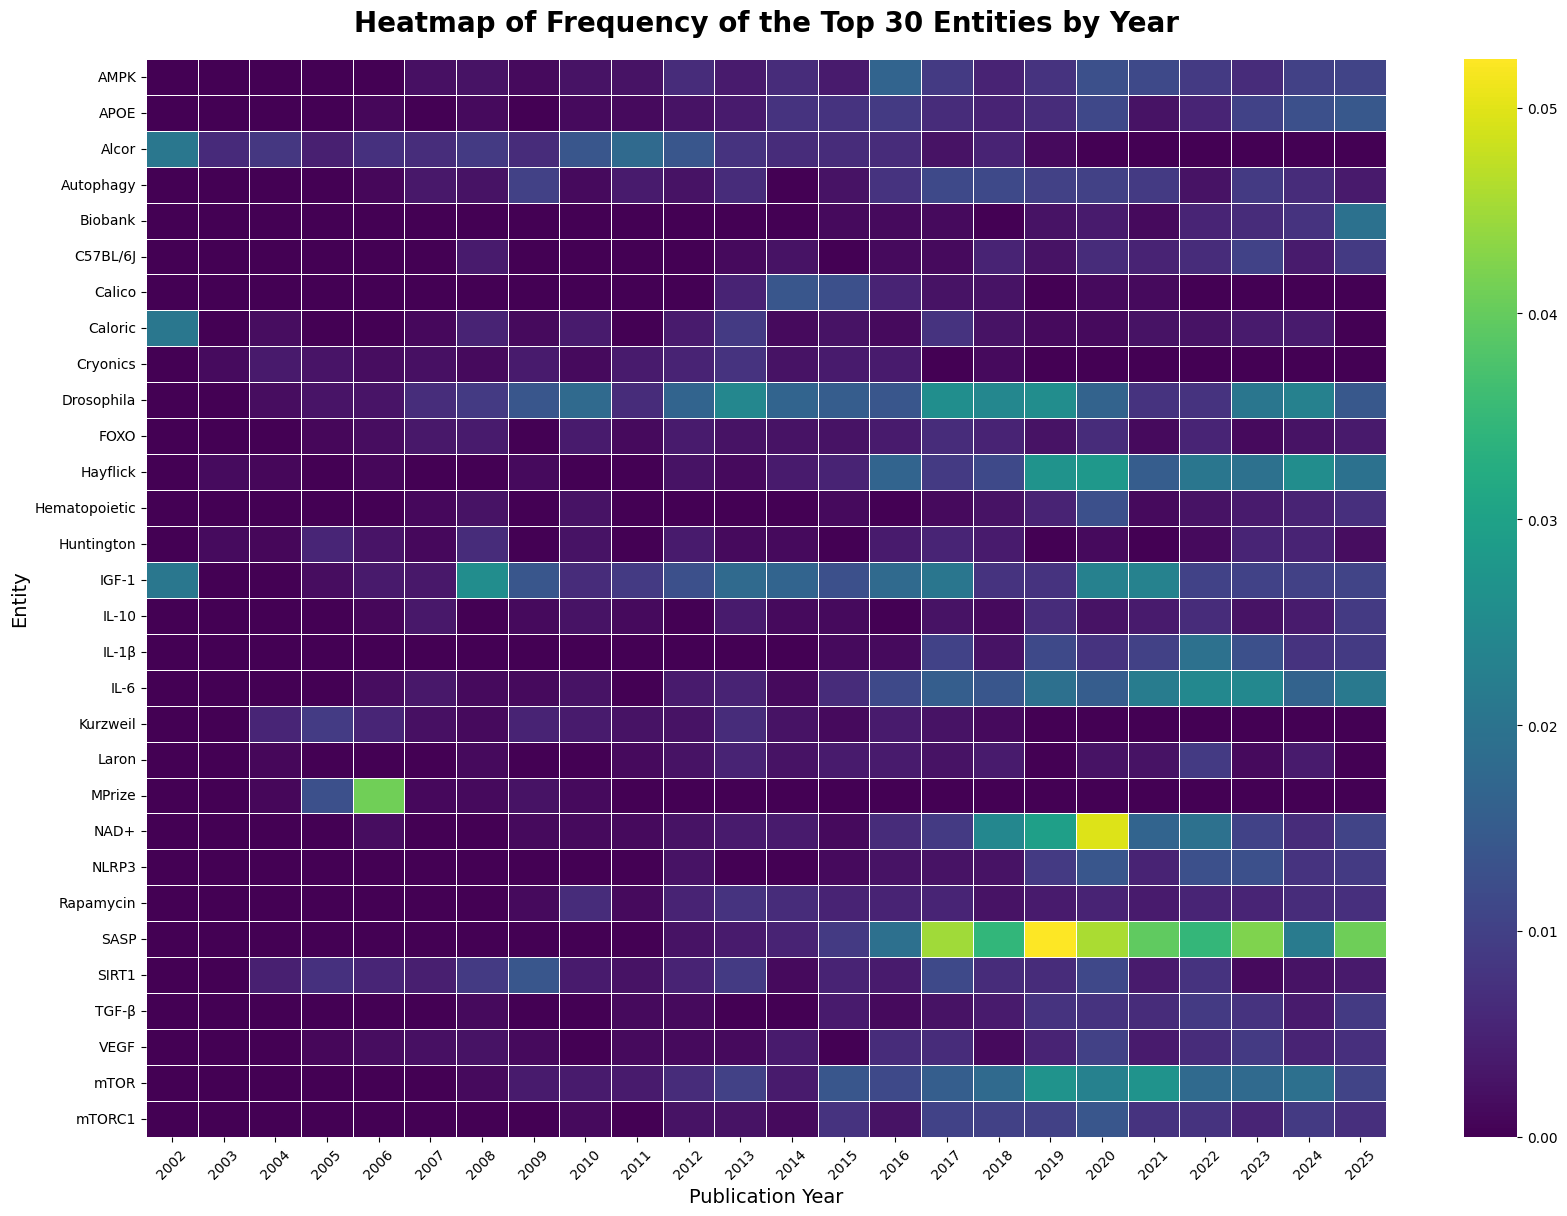

In [14]:
# STEP 7: HEATMAP VISUALIZATION

print("\n--- STEP 7: Generating Entity Trend Heatmap ---") # PASO 7: Generando Heatmap de Tendencias de Entidades

# We assume 'entity_trends' exists from the previous cell

# 1. Select the Top 30 entities for a more comprehensive view
N_TOP_ENTITIES = 30
top_entities = entity_trends.groupby('entity_name')['count'].sum().nlargest(N_TOP_ENTITIES).index
heatmap_df = entity_trends[entity_trends['entity_name'].isin(top_entities)]

# 2. Pivot the table for the heatmap format
heatmap_pivot = heatmap_df.pivot_table(
    index='entity_name', 
    columns='year', 
    values='frequency',
    fill_value=0 # Fill years with no mentions with 0
)

# 3. Visualization
plt.figure(figsize=(20, 14))
sns.heatmap(
    heatmap_pivot,
    cmap='viridis', # Color palette (darker = more frequent)
    linewidths=.5,
    annot=False # Set 'True' to see the numbers, but it can be noisy
)

plt.title(f'Heatmap of Frequency of the Top {N_TOP_ENTITIES} Entities by Year', fontsize=20, weight='bold', pad=20) # Heatmap de Frecuencia de las {N_TOP_ENTITIES} Principales Entidades por Año
plt.xlabel('Publication Year', fontsize=14) # Año de Publicación
plt.ylabel('Entity', fontsize=14) # Entidad
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig('2. NER_Analysis/heatmap_tendencias.png', dpi=300, bbox_inches='tight')
plt.show()


--- STEP 7b: Generating Facet Plots ---


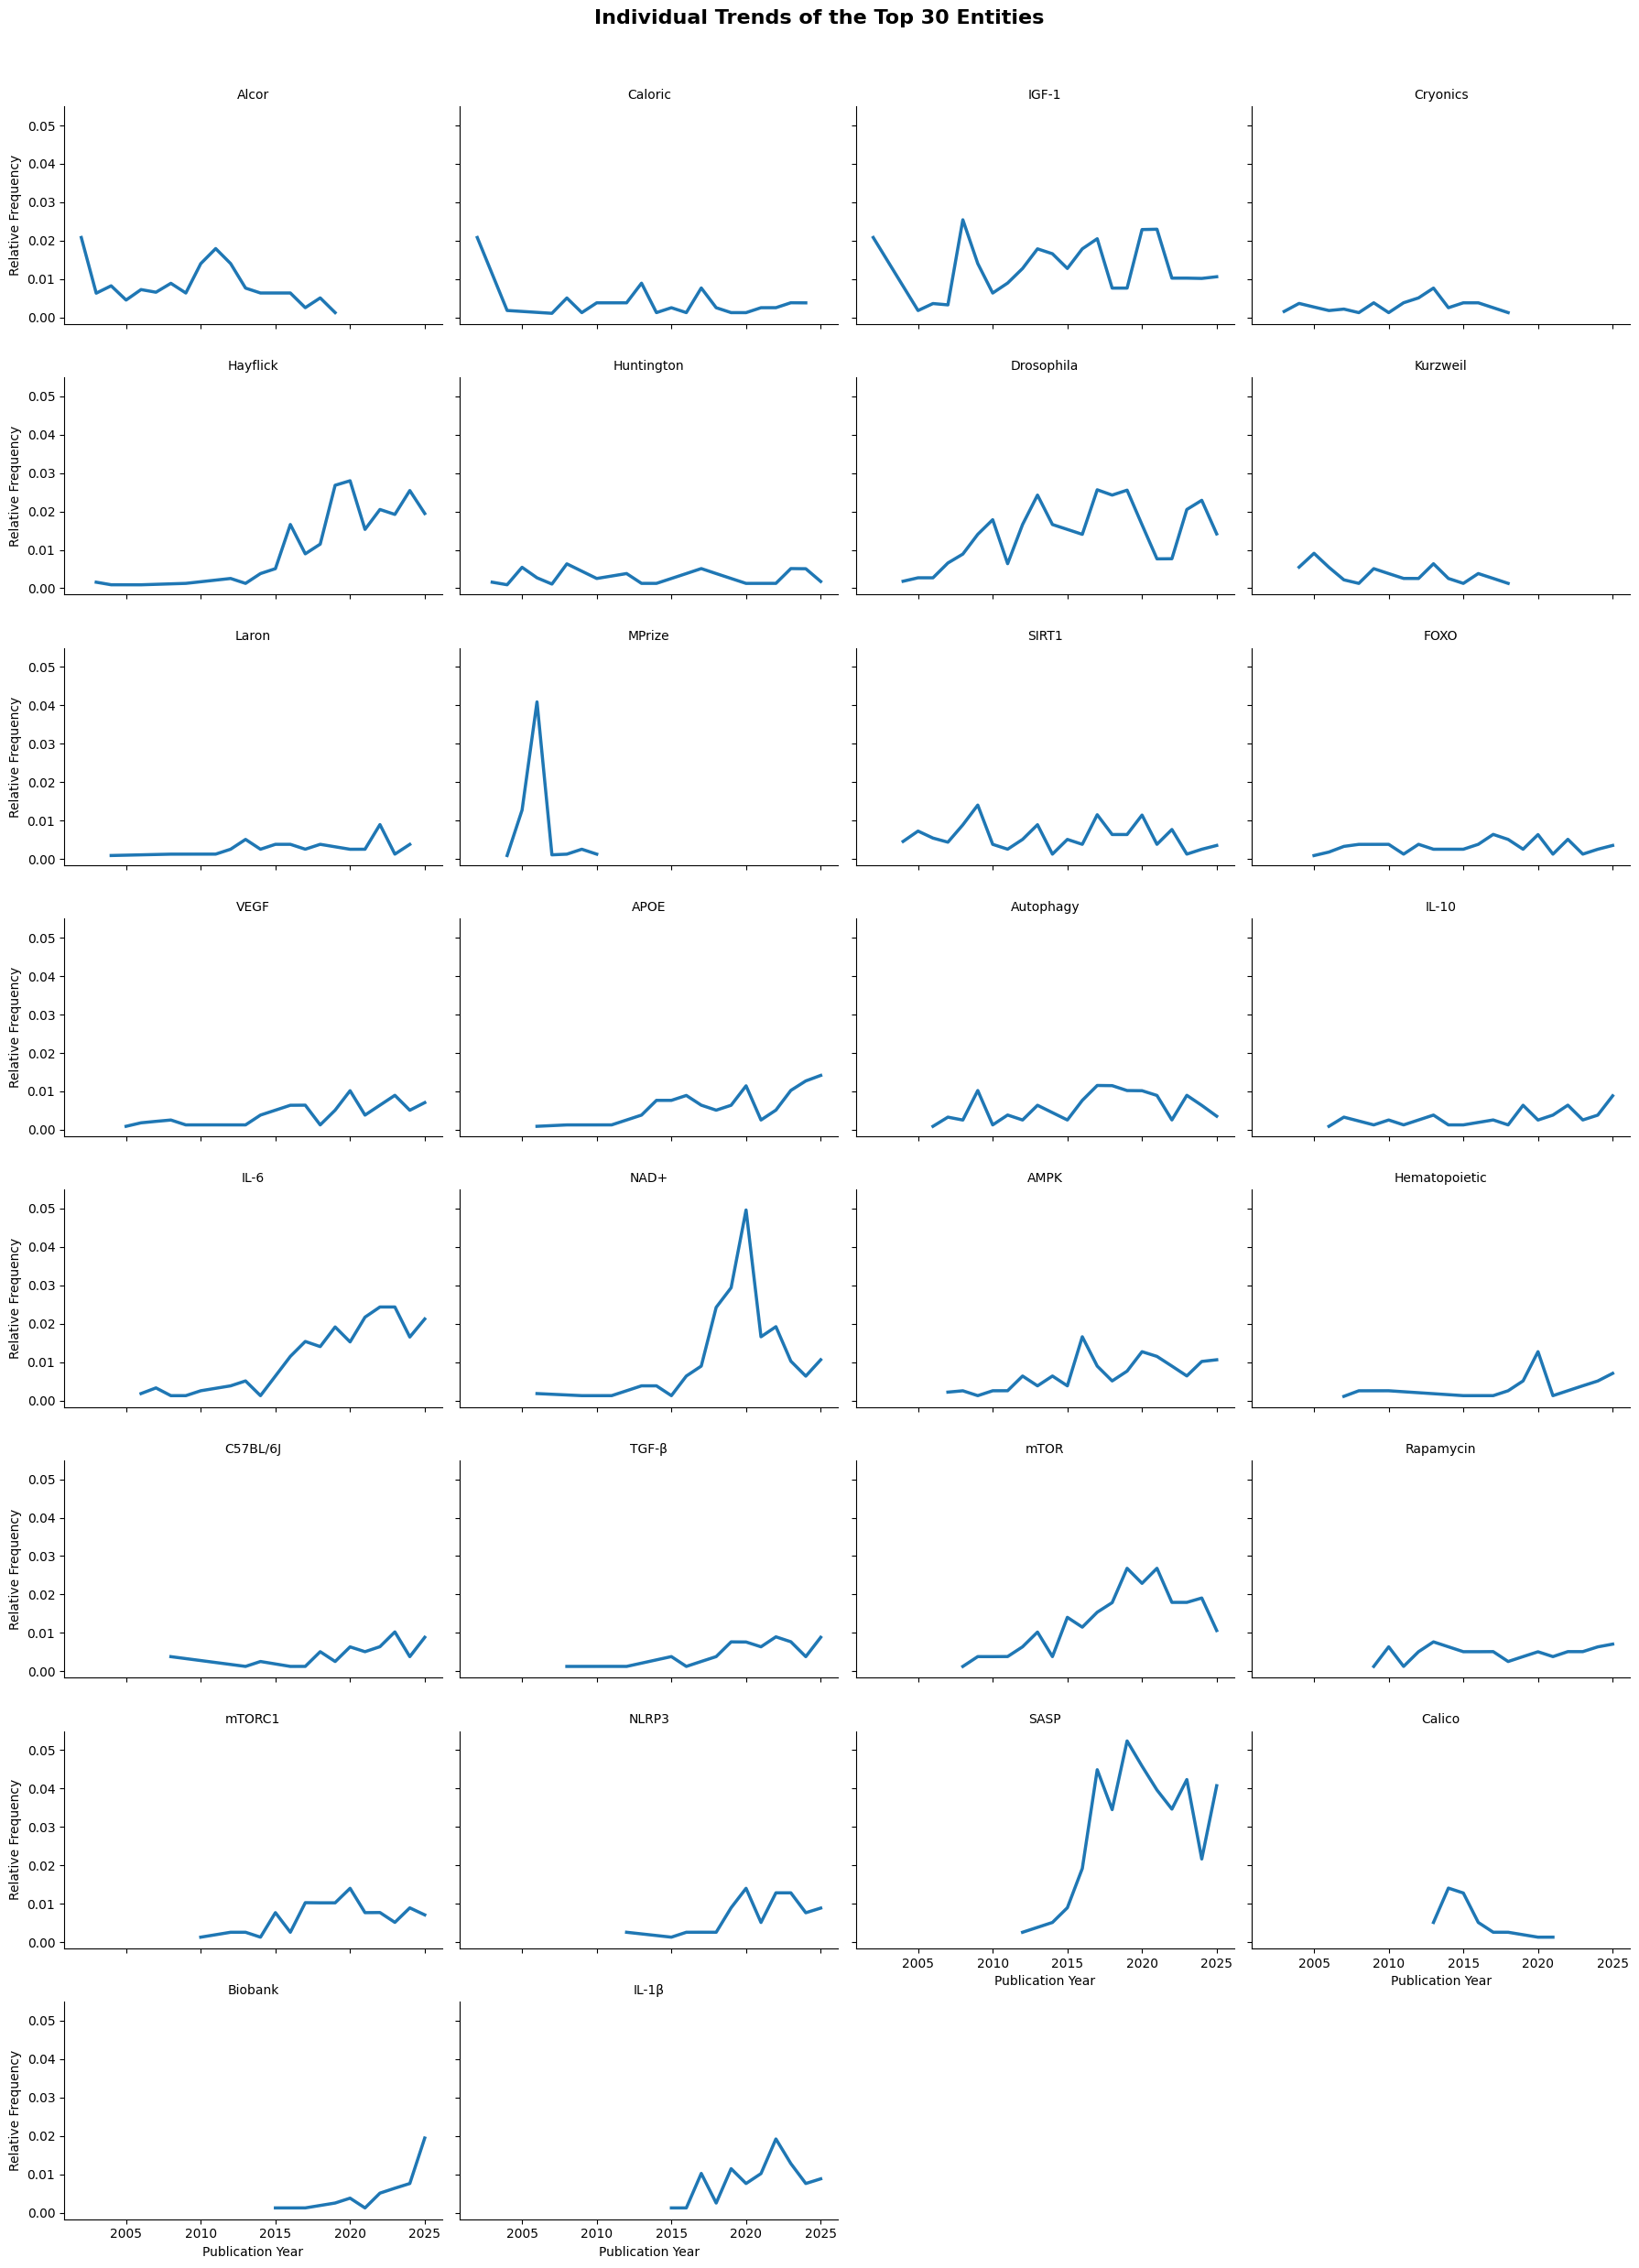

In [ ]:
# STEP 7b: FACET PLOT VISUALIZATION

print("\n--- STEP 7b: Generating Facet Plots ---")

# We use the same 'plot_df' from the Top 15 of your previous code
# (Or you can recalculate it with the N you prefer)
N_TOP_ENTITIES = 30
top_entities = entity_trends.groupby('entity_name')['count'].sum().nlargest(N_TOP_ENTITIES).index
facet_df = entity_trends[entity_trends['entity_name'].isin(top_entities)]


# We use relplot to automatically create the grid
g = sns.relplot(
    data=facet_df,
    x='year',
    y='frequency',
    col='entity_name', # Creates a column of plots for each entity
    col_wrap=4,        # Wraps the grid every 4 plots
    kind='line',       # The plot type is line
    height=3,          # Height of each small plot
    aspect=1.5,        # Aspect ratio
    linewidth=2.5
)

g.fig.suptitle(f'Individual Trends of the Top {N_TOP_ENTITIES} Entities', y=1.03, fontsize=16, weight='bold')
g.set_titles("{col_name}")
g.set_axis_labels("Publication Year", "Relative Frequency")
plt.savefig('2. NER_Analysis/facet_grid_tendencias.png', dpi=300, bbox_inches='tight')
plt.show()